In [1]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [2]:
prefix='../bench-results-final/'

In [62]:
names = ['throughput', 'latency']
pidstat_names = ['timestamp', 'wait', 'used', 'core', 'command']

def import_simple(path, additional_names=[]):
    tmp = pd.read_csv(f"{path}/sock.csv", names=additional_names+names)
    tmp['throughput'] /= 1024
    tmp['latency'] /= 1000
    tmp_cpu = pd.read_csv(f"{path}/pidstat.csv", names=additional_names+pidstat_names)
    tmp_cpu = tmp_cpu.groupby(additional_names + ['core', 'timestamp']).sum(numeric_only=True).reset_index() 
    tmp_cpu = tmp_cpu.groupby(additional_names + ['core']).median(numeric_only=True).reset_index()
    # global_cpu = tmp.groupby(['cpu', 'client']).mean().reset_index()
    tmp['cpu'] = tmp_cpu.mean()['used']
    tmp['cpu_efficiency'] = tmp['throughput'] / tmp['cpu']
    return tmp

In [63]:
benchmarks = os.listdir(prefix)
list(enumerate(benchmarks))

[(0, 'benchmark-wireguard-steering'),
 (1, 'benchmark-vanilla'),
 (2, 'benchmark-wireguard-multi-queue-pool'),
 (3, 'benchmark-wireguard-no-queue'),
 (4, 'benchmark-wireguard-batch'),
 (5, 'benchmark-wireguard-multi-queue-pool-steering')]

In [152]:
vanilla_path = f"{prefix}/{benchmarks[1]}/summary"
vanilla = import_simple(vanilla_path)
vanilla['variant'] = 'VANILLA'
vanilla

,throughput,latency,cpu,cpu_efficiency,variant
0,19.237766,124.675,100.0,0.192378,VANILLA


In [153]:
no_queue_path = f"{prefix}/{benchmarks[3]}/summary"
no_queue = import_simple(no_queue_path)
no_queue['variant'] = 'NO_QUEUE'
no_queue

,throughput,latency,cpu,cpu_efficiency,variant
0,20.854481,88.661387,31.909444,0.653552,NO_QUEUE


In [154]:
batched_path = f"{prefix}/{benchmarks[4]}/summary"
batched = import_simple(batched_path, additional_names=['batch'])
batched['variant'] = 'BATCHED'
batched

,batch,throughput,latency,cpu,cpu_efficiency,variant
0,2,17.200130,90.0547,81.927917,0.209942,BATCHED
1,4,20.688951,52.0277,81.927917,0.252526,BATCHED
2,8,20.698024,54.0868,81.927917,0.252637,BATCHED
3,16,20.654782,55.3418,81.927917,0.252109,BATCHED


In [155]:
mq_path = f"{prefix}/{benchmarks[2]}/summary"
mq = import_simple(mq_path, additional_names=['rings'])
mq['variant'] = 'MULTI_QUEUE'
mq

,rings,throughput,latency,cpu,cpu_efficiency,variant
2,2,18.286656,90.7372,51.30137,0.356456,MULTI_QUEUE
4,4,13.457654,63.6597,51.30137,0.262325,MULTI_QUEUE
8,8,13.057269,152.2170,51.30137,0.254521,MULTI_QUEUE
18,18,6.020771,327.1400,51.30137,0.117361,MULTI_QUEUE


In [176]:
mq_steering_path = f"{prefix}/{benchmarks[5]}/summary"
mq_steering = import_simple(mq_steering_path, additional_names=['rings'])
mq_steering['variant'] = 'MULTI_QUEUE'
mq_steering

,rings,throughput,latency,cpu,cpu_efficiency,variant
2,2,19.583487,46.252000,80.701389,0.242666,MULTI_QUEUE
4,4,19.719093,20.865600,80.701389,0.244346,MULTI_QUEUE
8,8,20.262790,28.868865,80.701389,0.251084,MULTI_QUEUE
18,18,20.844239,91.517054,80.701389,0.258288,MULTI_QUEUE


# Batched

In [157]:
def plot_(df, x, y, xlabel, ylabel, normal_value, text_offset=0, text_spacing=.1, ylim=None, logy=False):
    with plt.style.context(['science', 'ieee']):
        ax = df.plot.bar(x=x, y=y, grid=True, ylim=ylim, logy=logy,
                         ylabel=ylabel, xlabel=xlabel,
                        legend=None)
        ax.axhline(y=normal_value, color='red', linestyle='--', label='vanilla')
        ax.annotate(
            f'VANILLA', 
            xy=(2, normal_value), 
            xytext=(text_offset, normal_value+text_spacing), fontsize=8, color='red'
    #                     textcoords='offset point'
        )
        plt.xticks(rotation=0)
        plt.show()

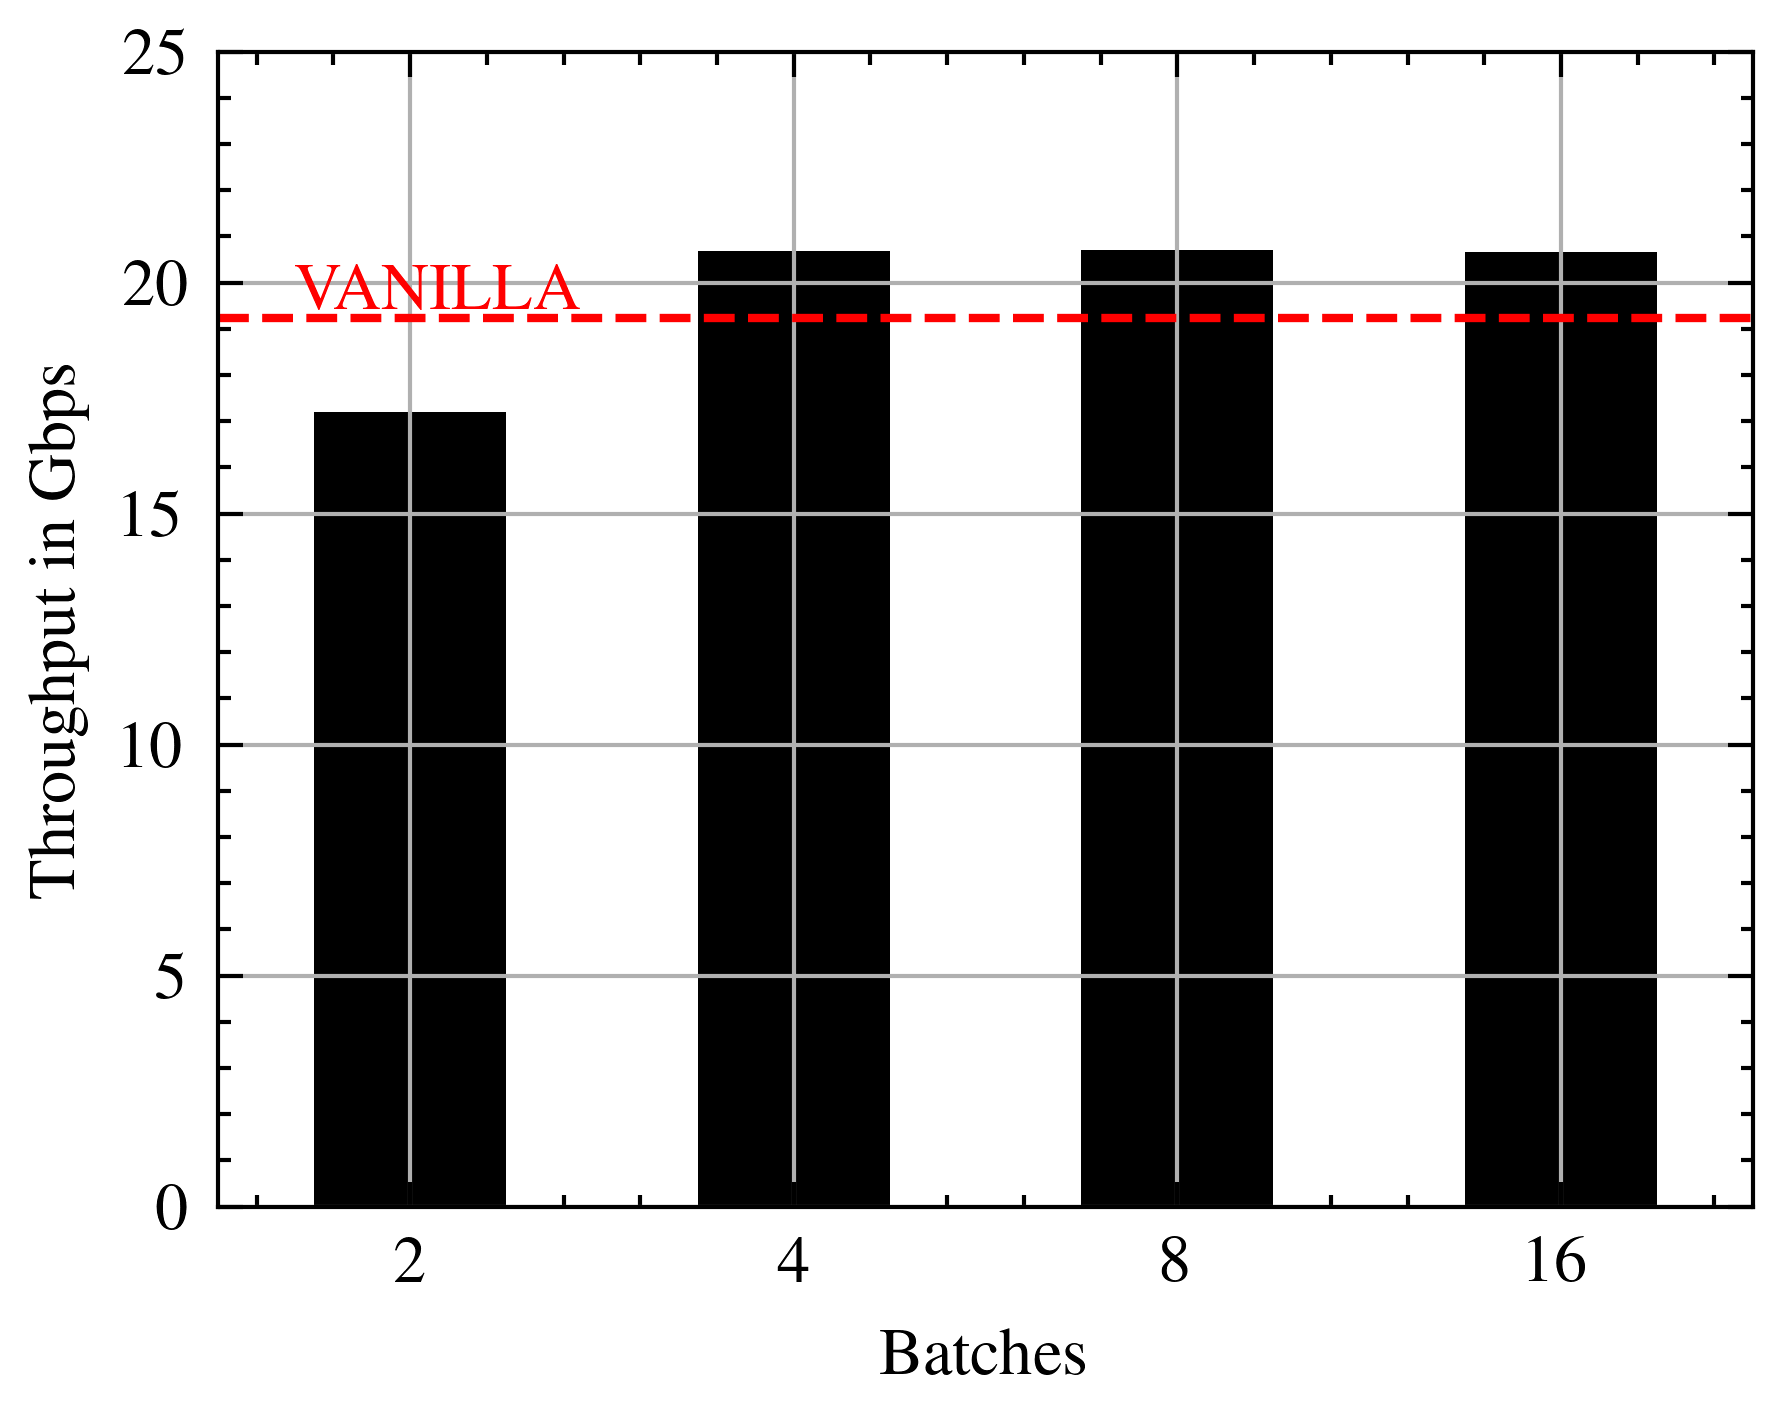

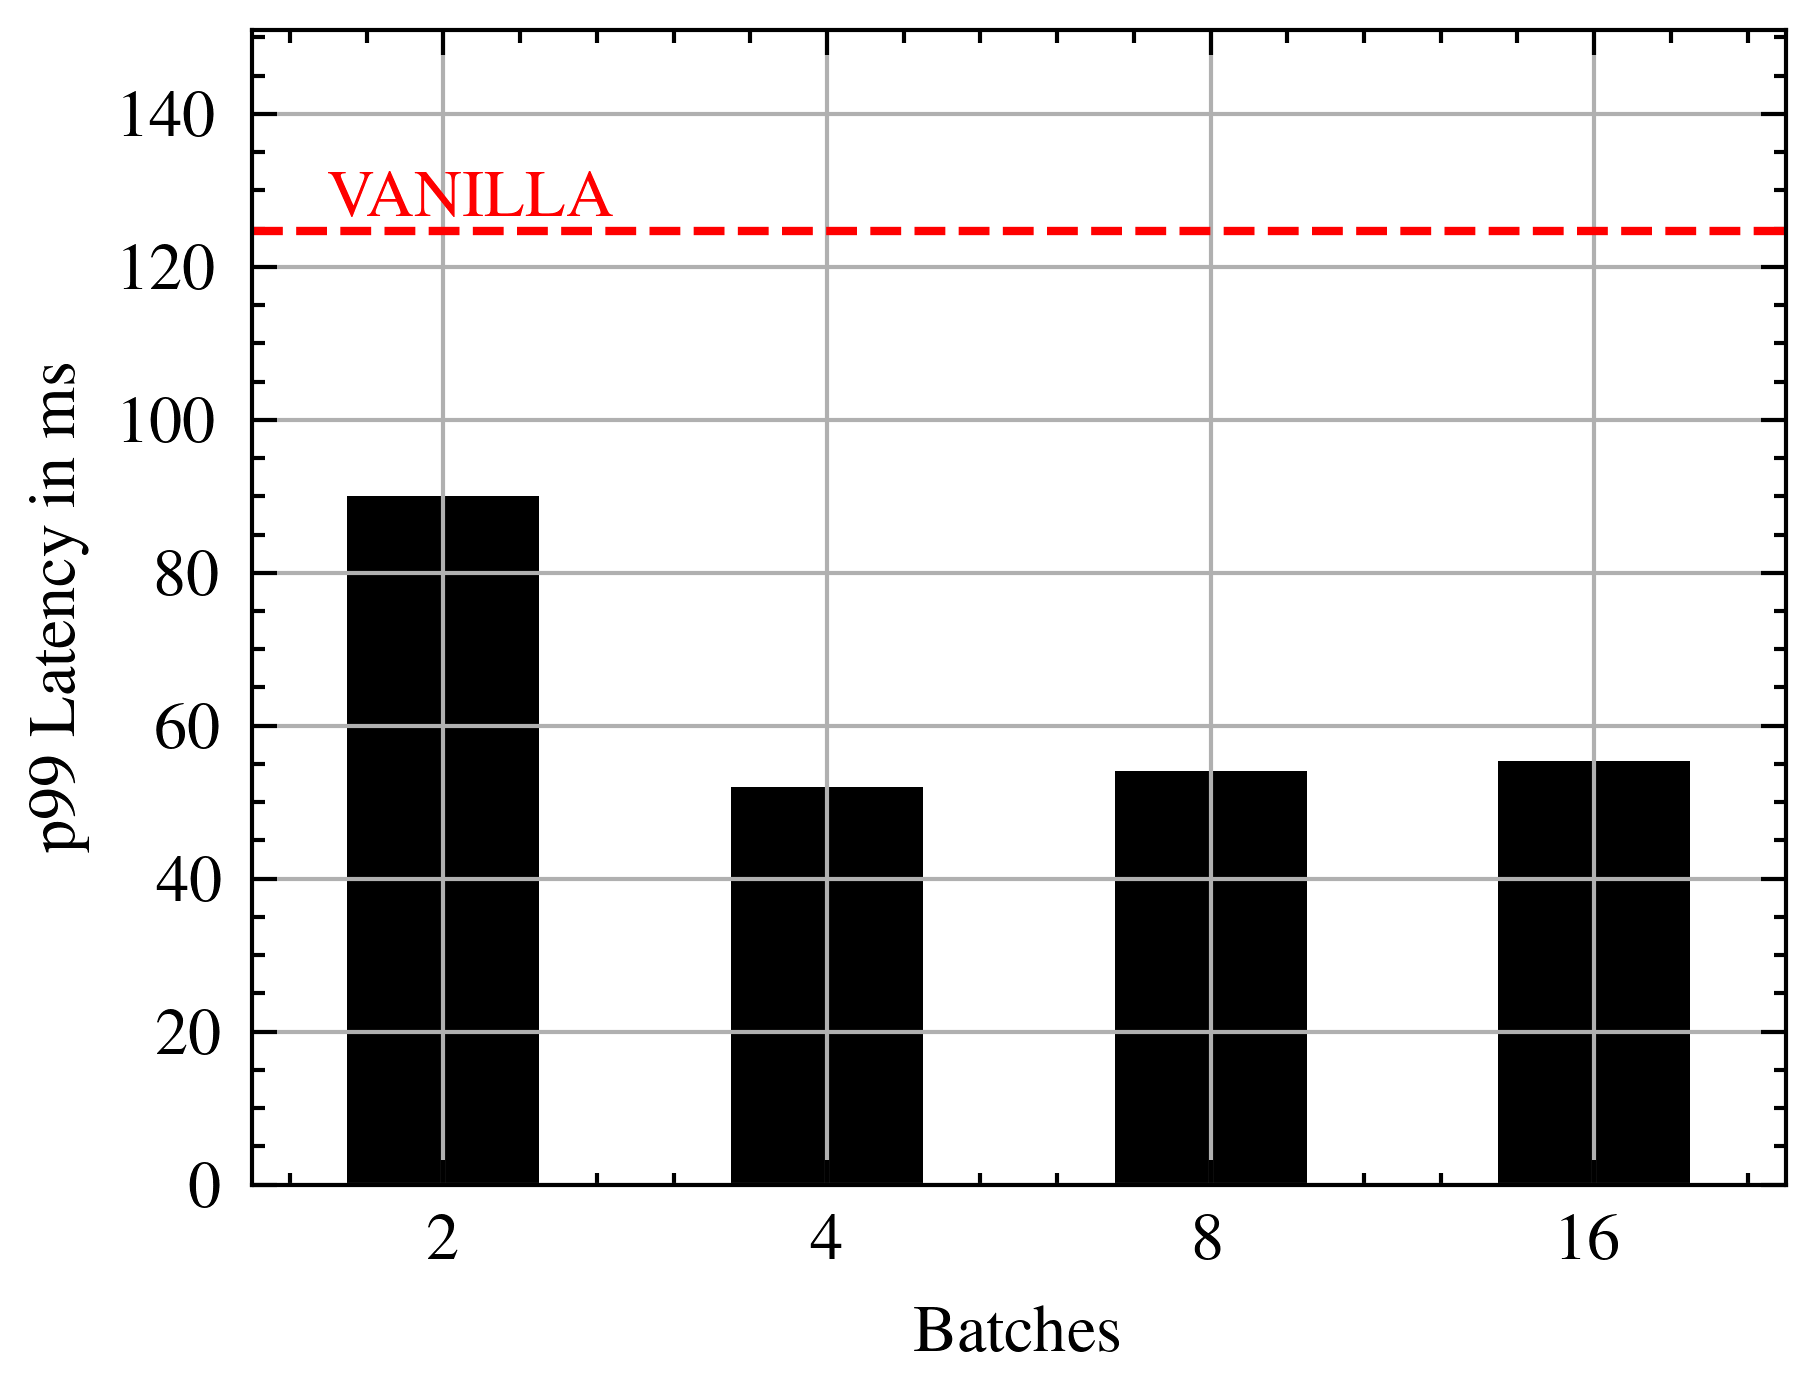

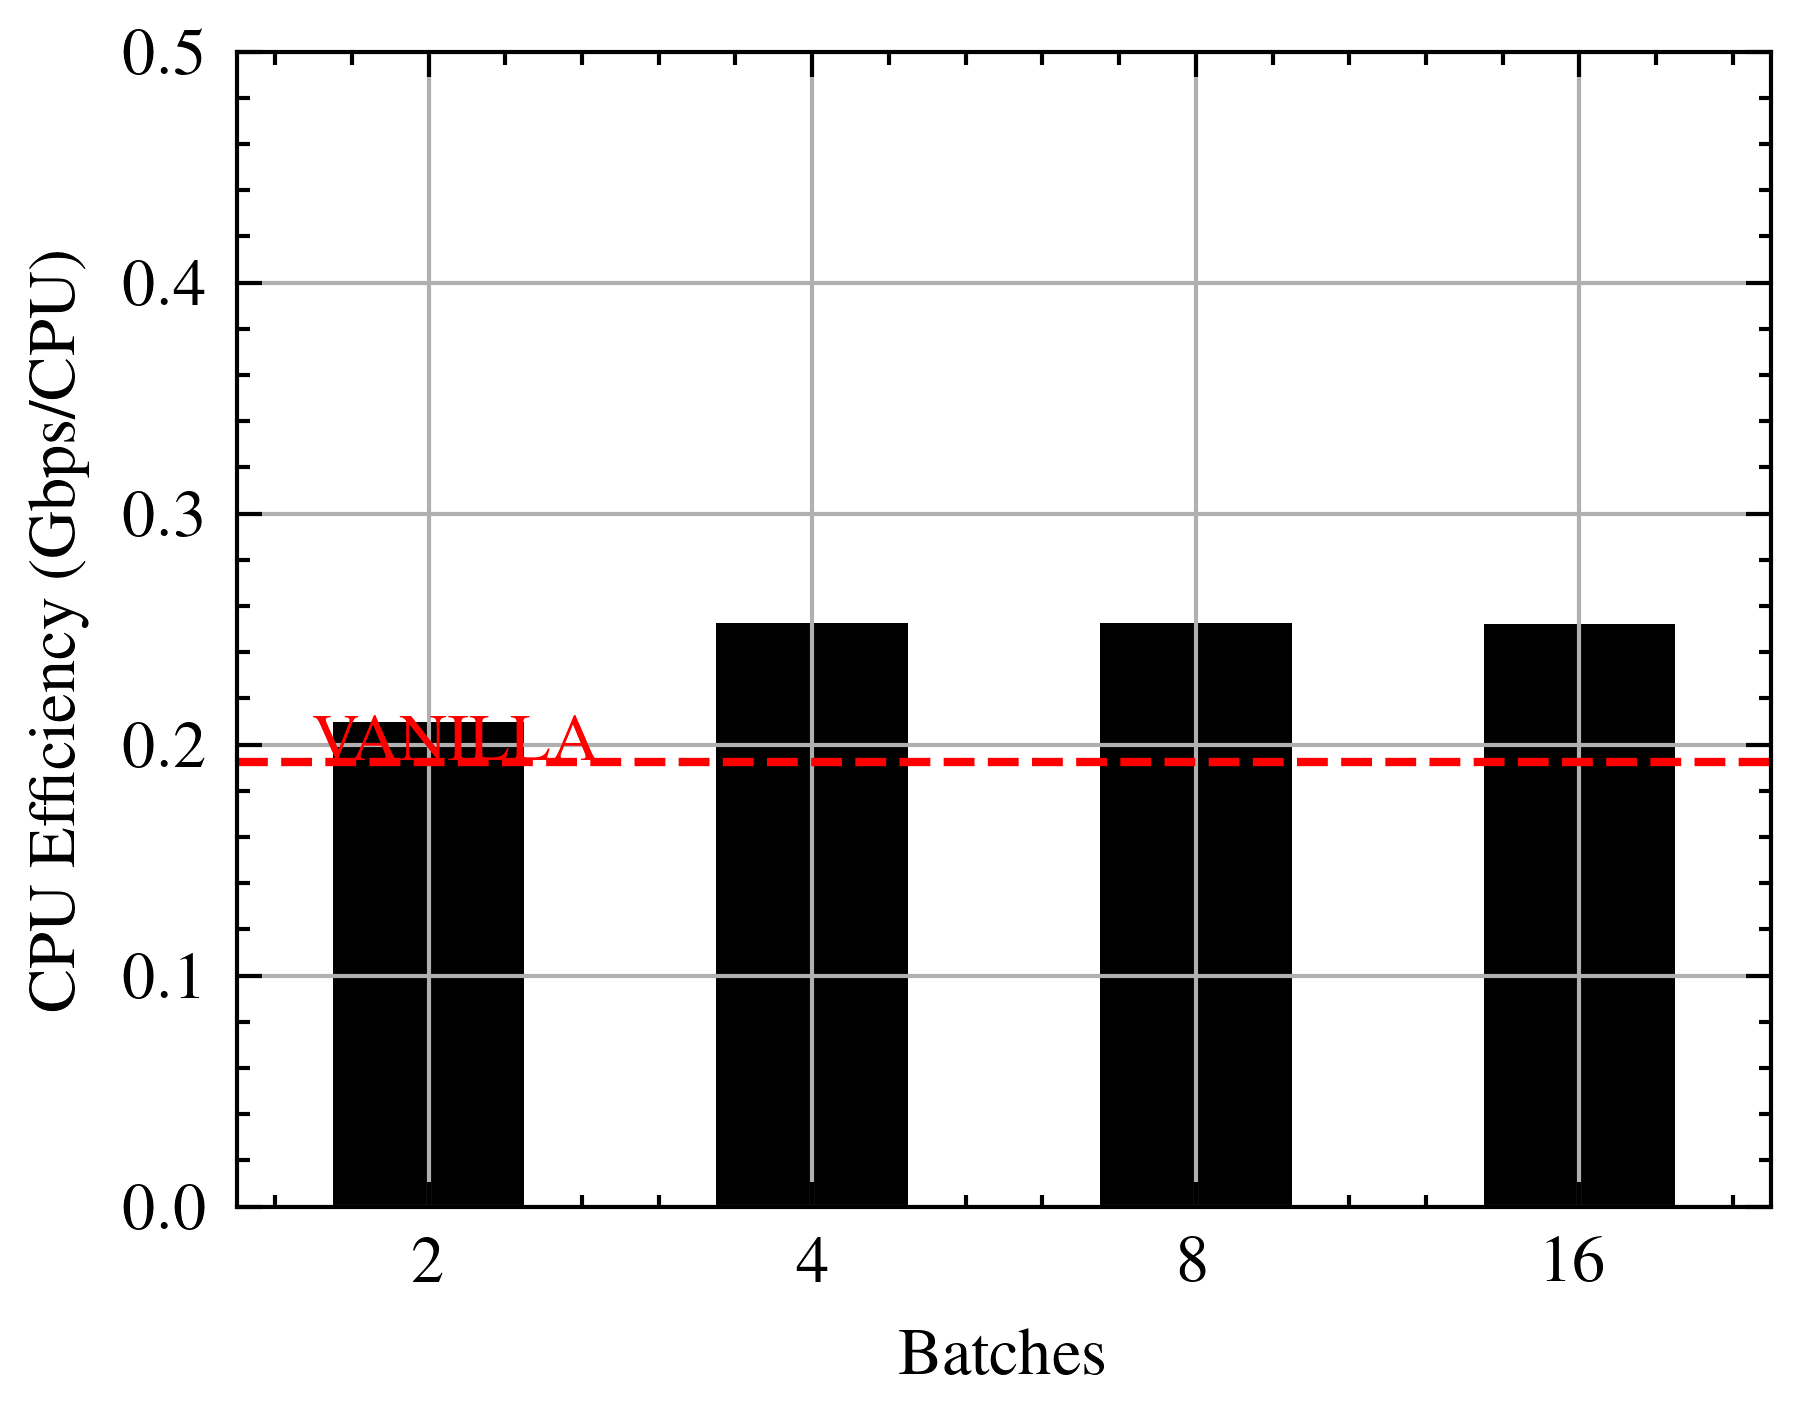

In [158]:
df = batched
x = 'batch'

plot_(
    df, x=x, y='throughput', ylim=[0, 25],
    xlabel='Batches', ylabel='Throughput in Gbps',
    normal_value=vanilla['throughput'].iloc[0],
    text_spacing=.2, text_offset=-0.3
)

plot_(
    df, x=x, y='latency', ylim=[0, 151],
    xlabel='Batches', ylabel='p99 Latency in ms',
    normal_value=vanilla['latency'].iloc[0],
    text_spacing=2, text_offset=-0.3
)

metric = 'cpu_efficiency'
plot_(
    df, x=x, y=metric, ylim=[0, .5],
    xlabel='Batches', ylabel='CPU Efficiency (Gbps/CPU)',
    normal_value=vanilla[metric].iloc[0],
    text_spacing=.001, text_offset=-0.3
)

# Multi_Queue

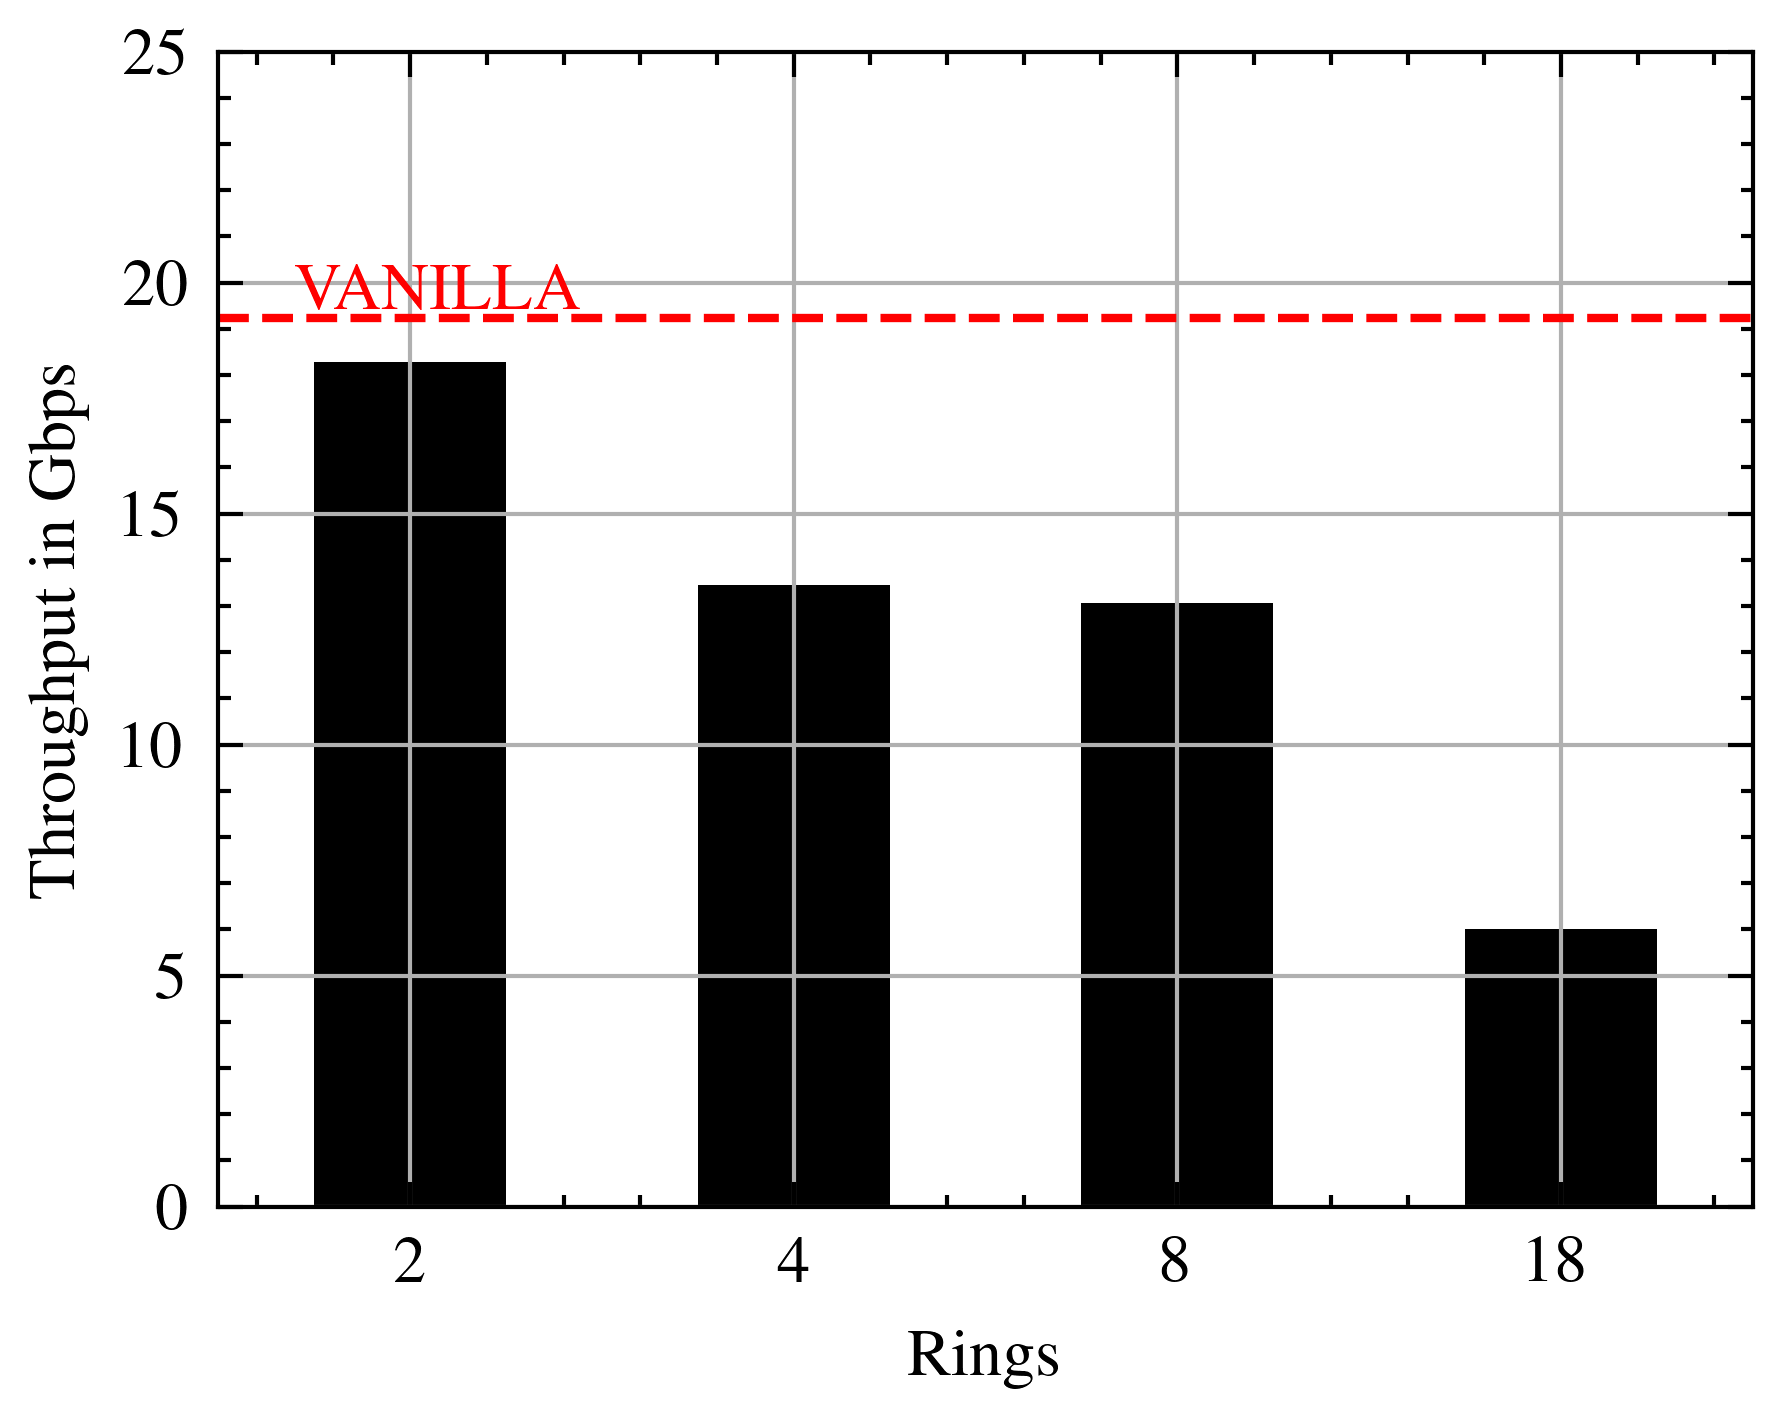

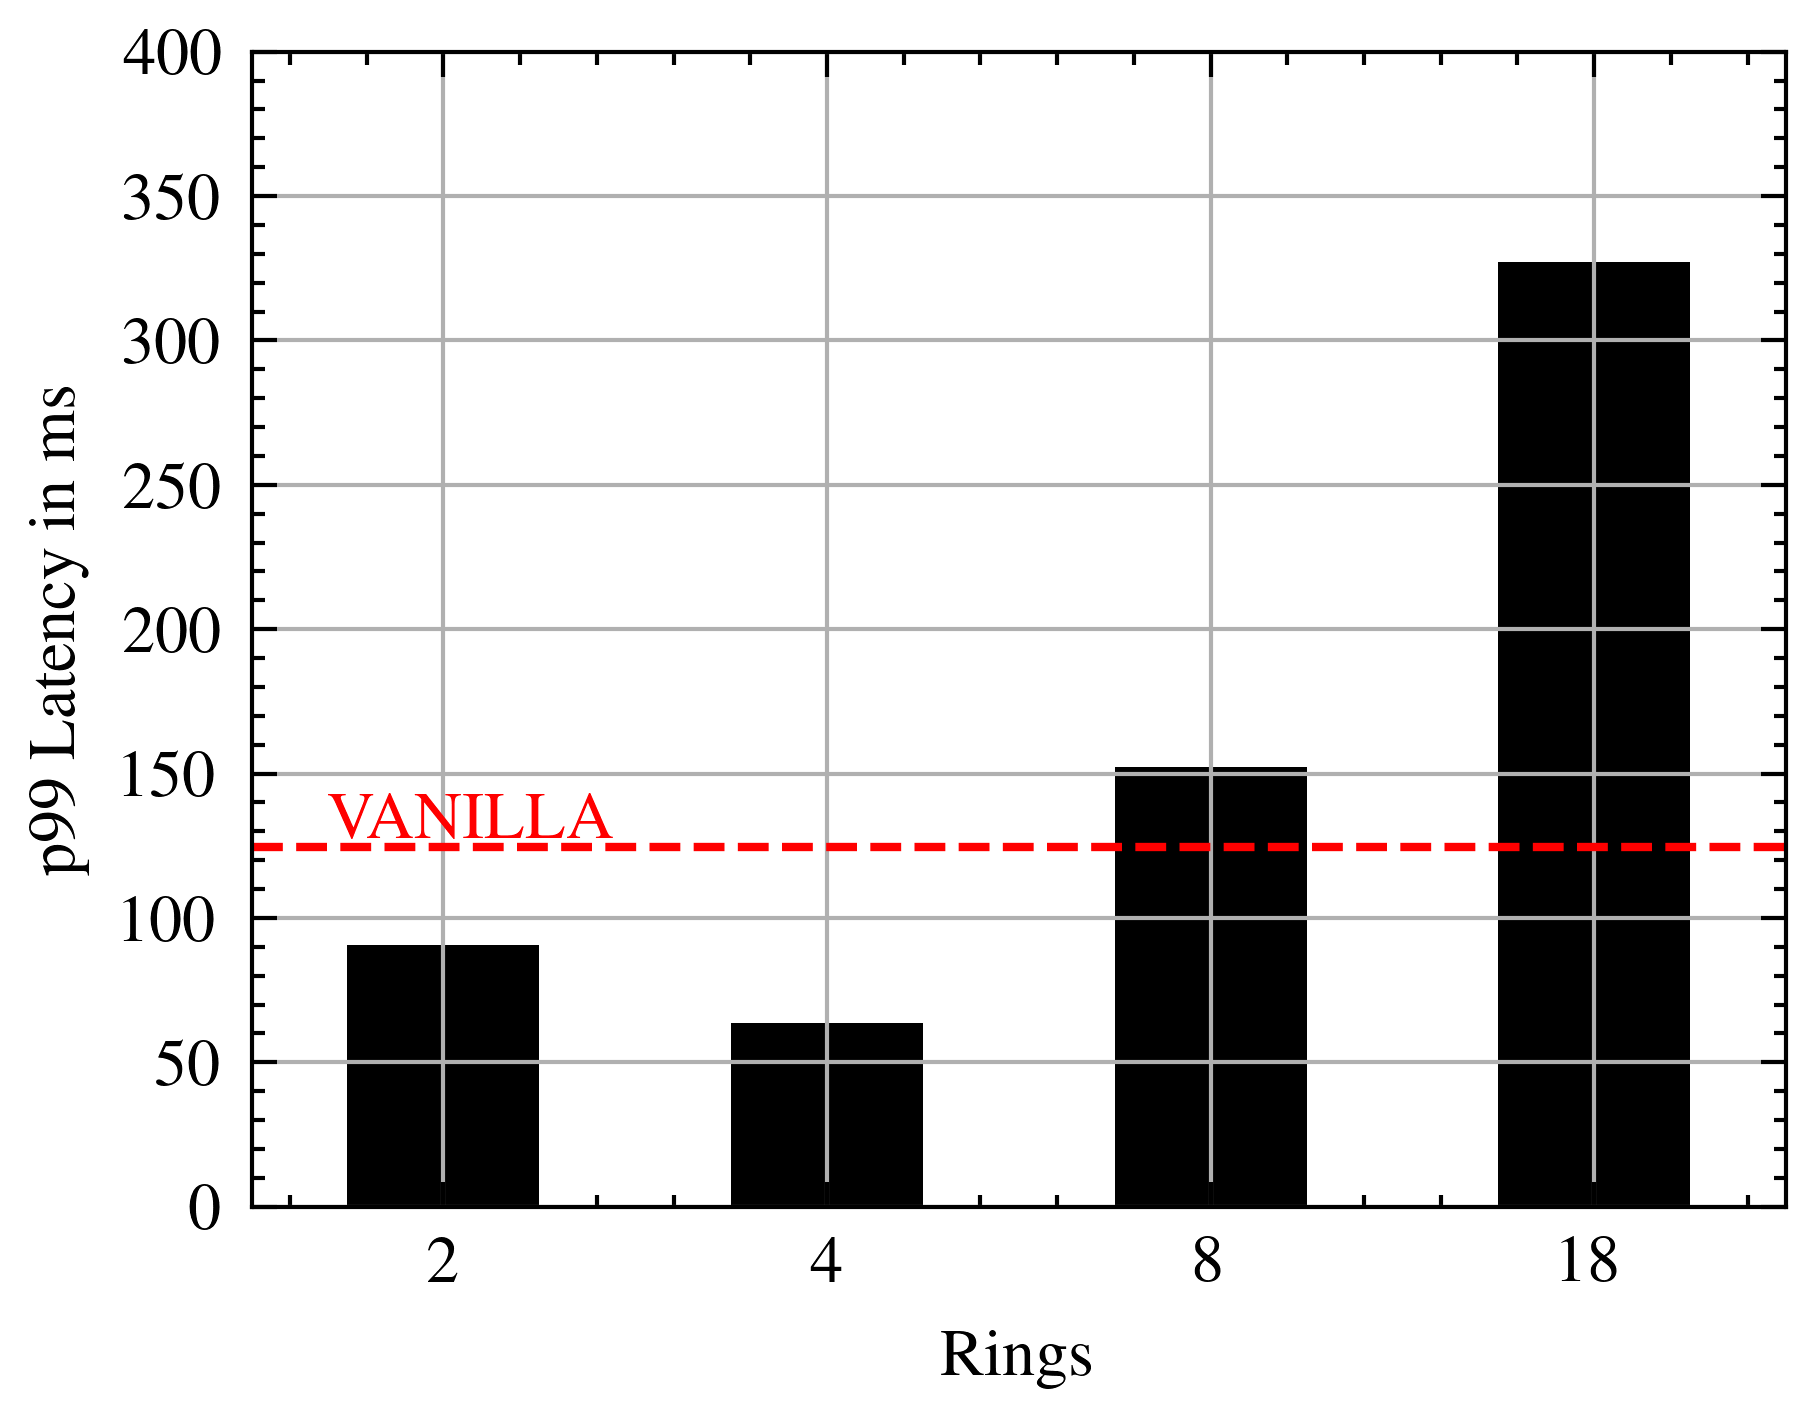

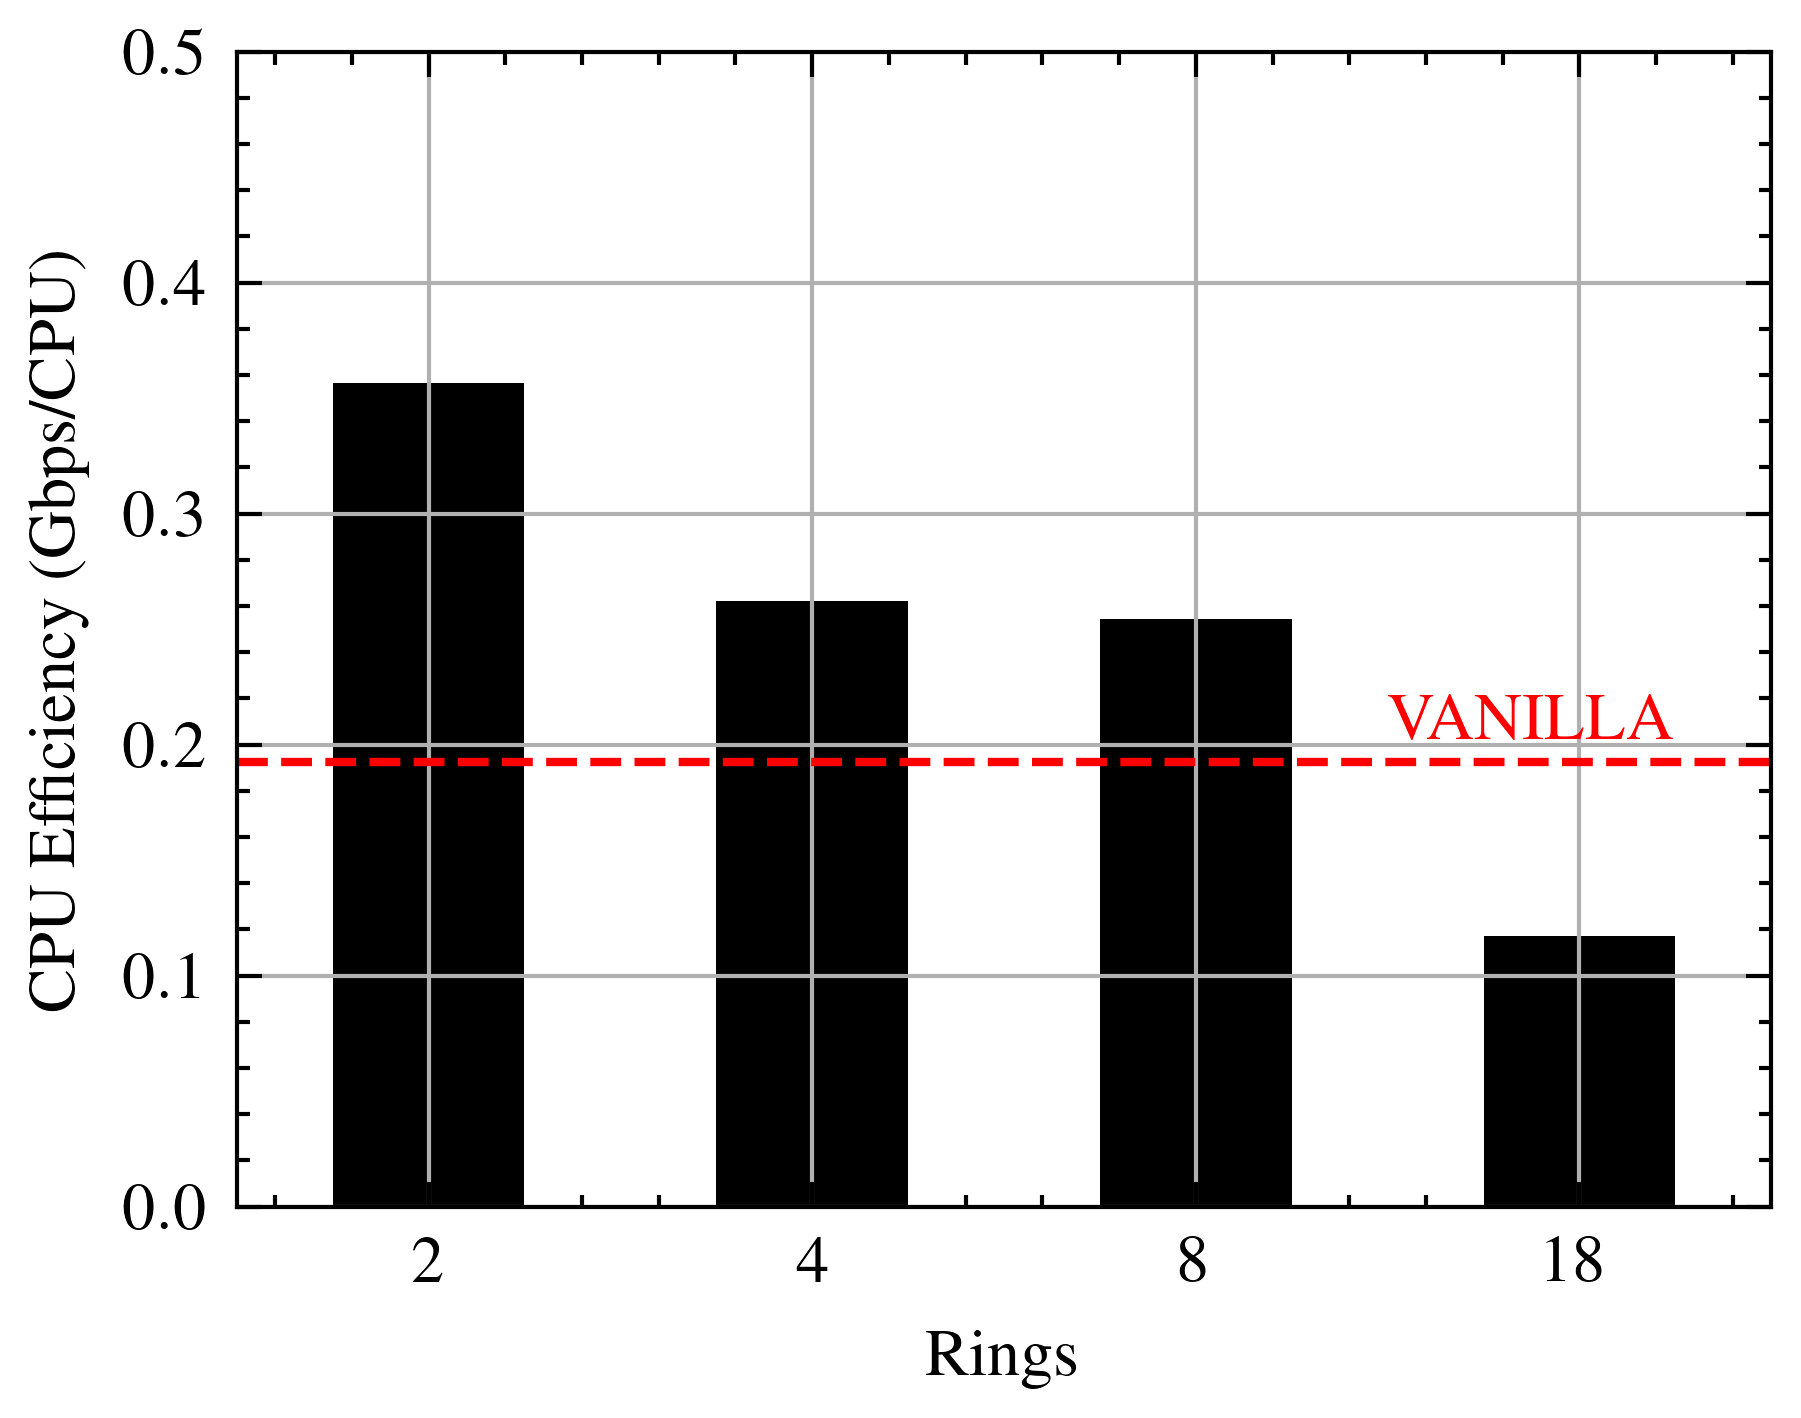

In [159]:
df = mq
x = 'rings'

plot_(
    df, x=x, y='throughput', ylim=[0, 25],
    xlabel='Rings', ylabel='Throughput in Gbps',
    normal_value=vanilla['throughput'].iloc[0],
    text_spacing=.2, text_offset=-0.3
)

plot_(
    df, x=x, y='latency', ylim=[0, 400],
    xlabel='Rings', ylabel='p99 Latency in ms',
    normal_value=vanilla['latency'].iloc[0],
    text_spacing=3, text_offset=-0.3
)

metric = 'cpu_efficiency'
plot_(
    df, x=x, y=metric, ylim=[0, .5],
    xlabel='Rings', ylabel='CPU Efficiency (Gbps/CPU)',
    normal_value=vanilla[metric].iloc[0],
    text_spacing=.01, text_offset=2.5
)

# Multi Queue Steering

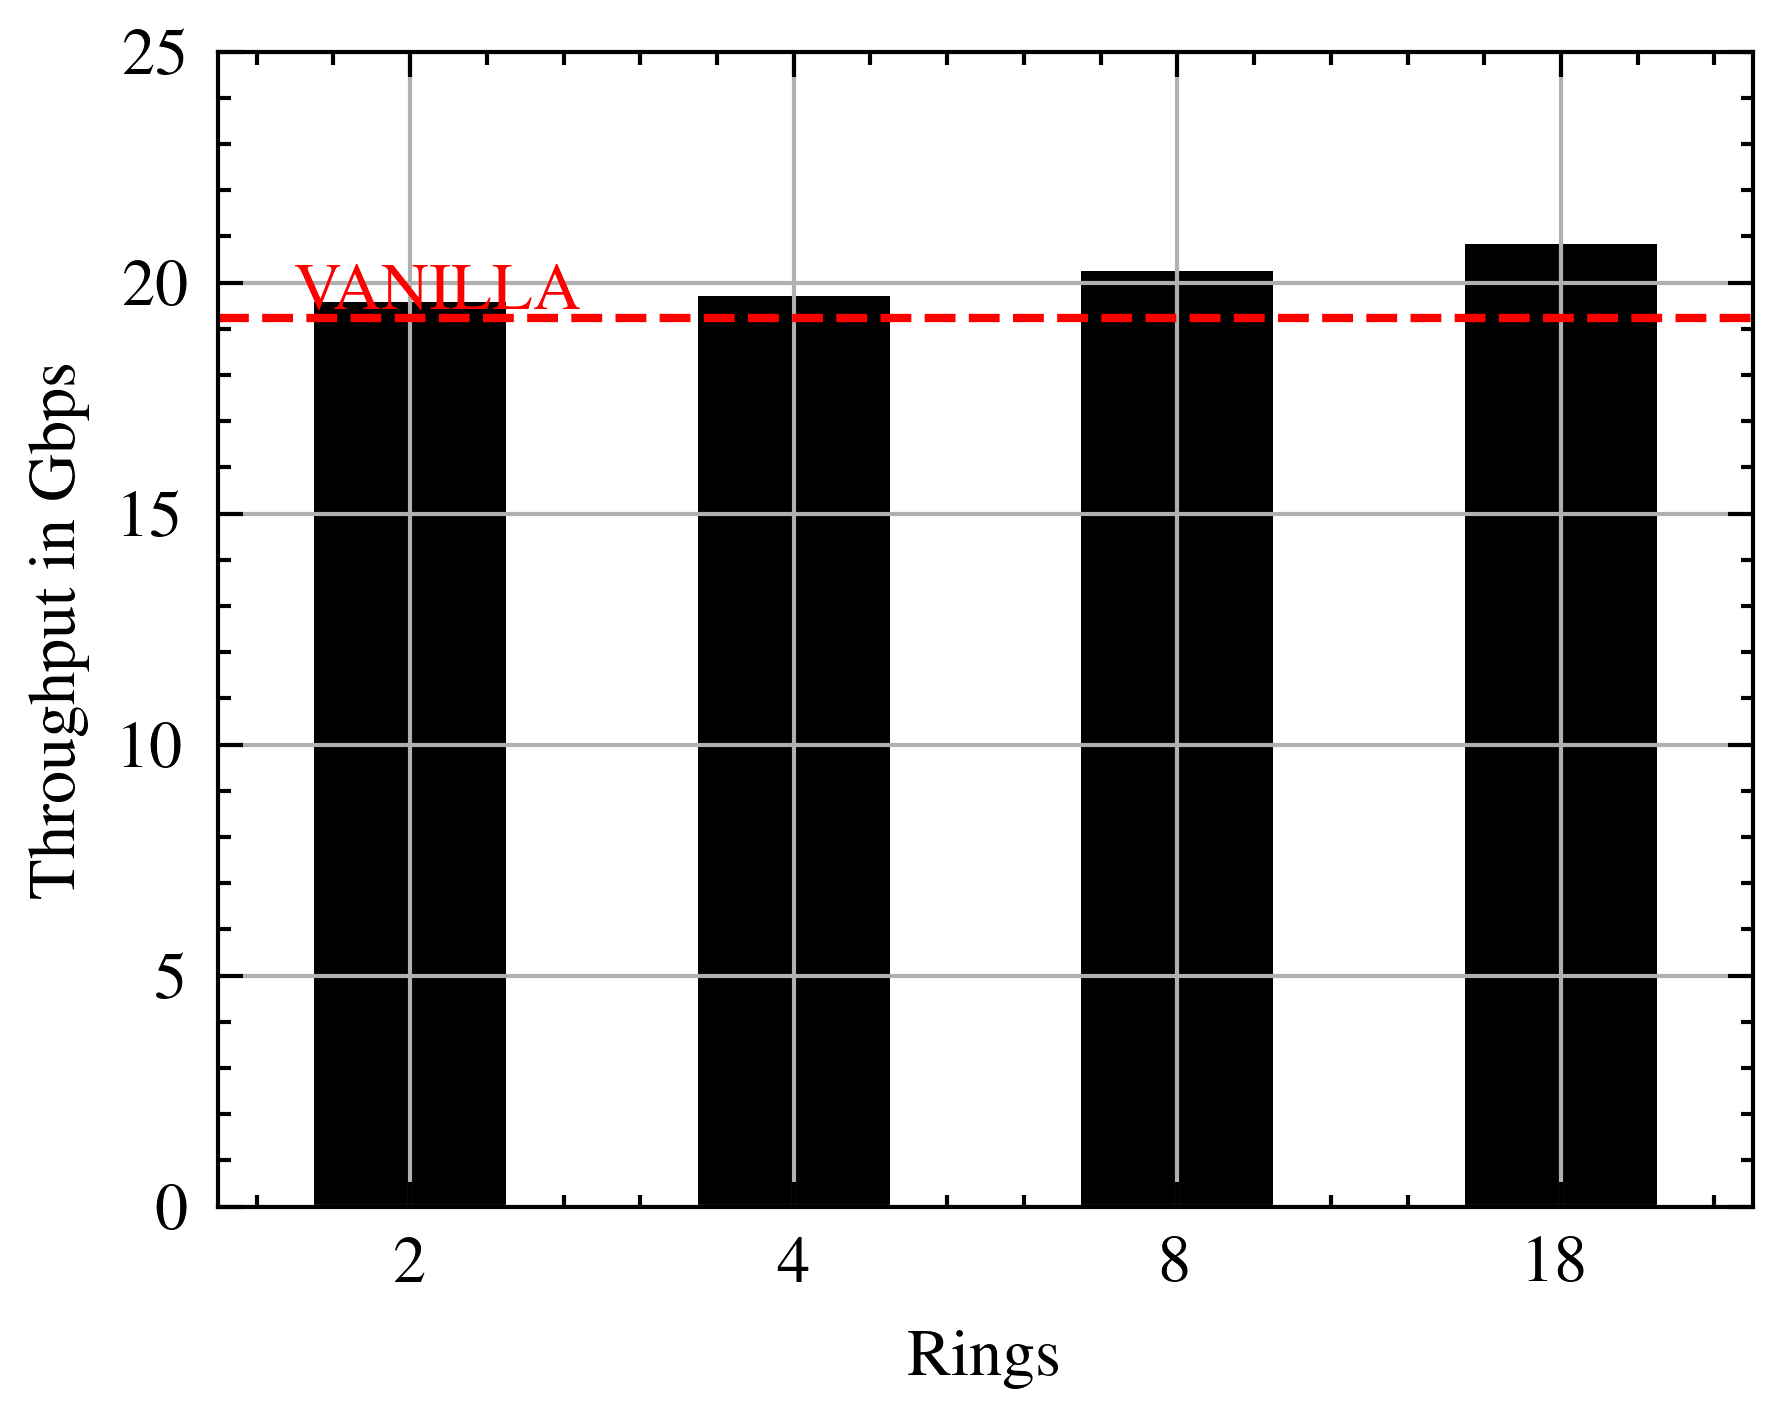

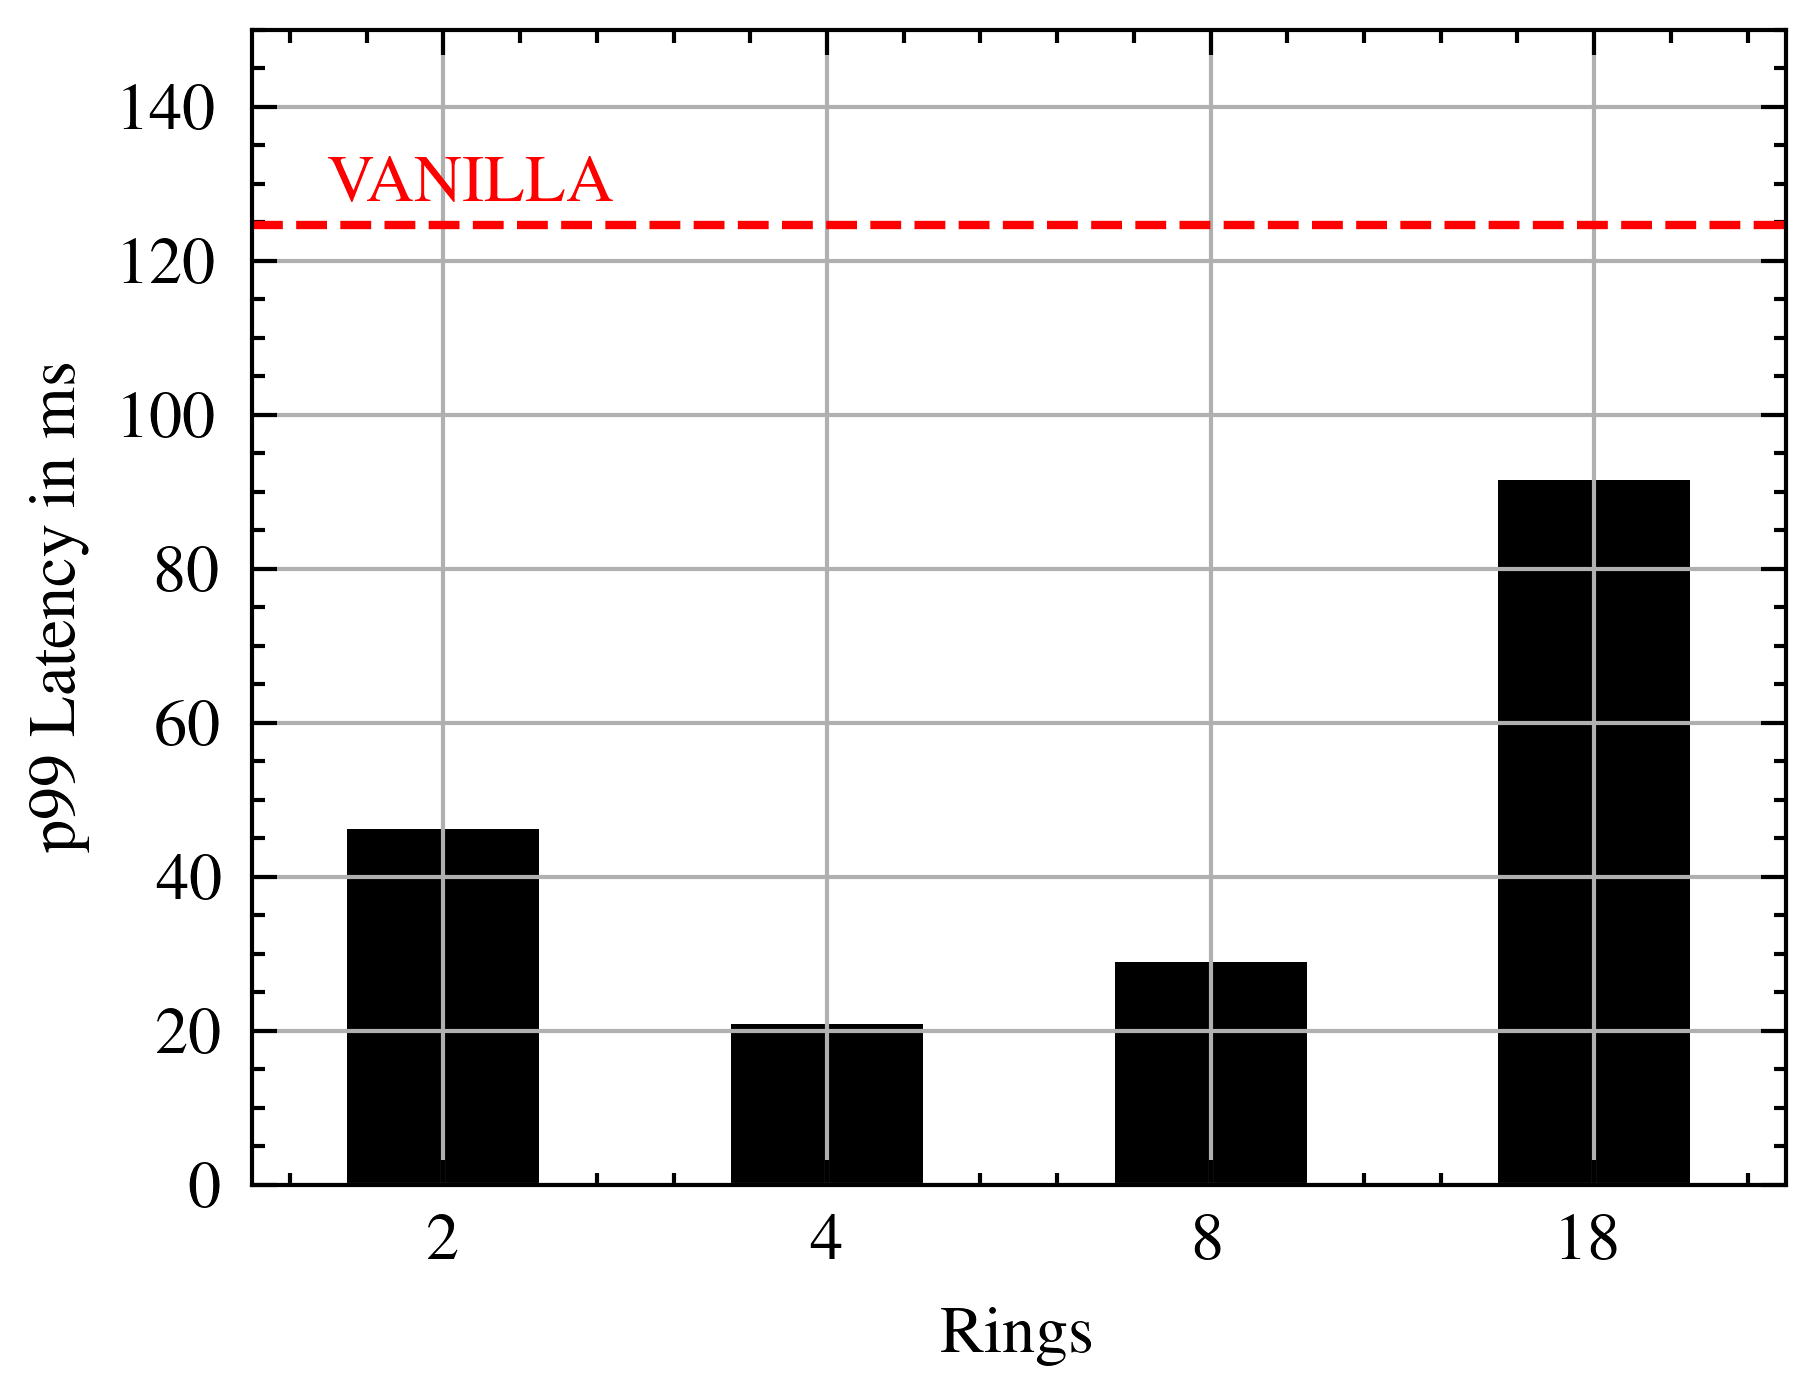

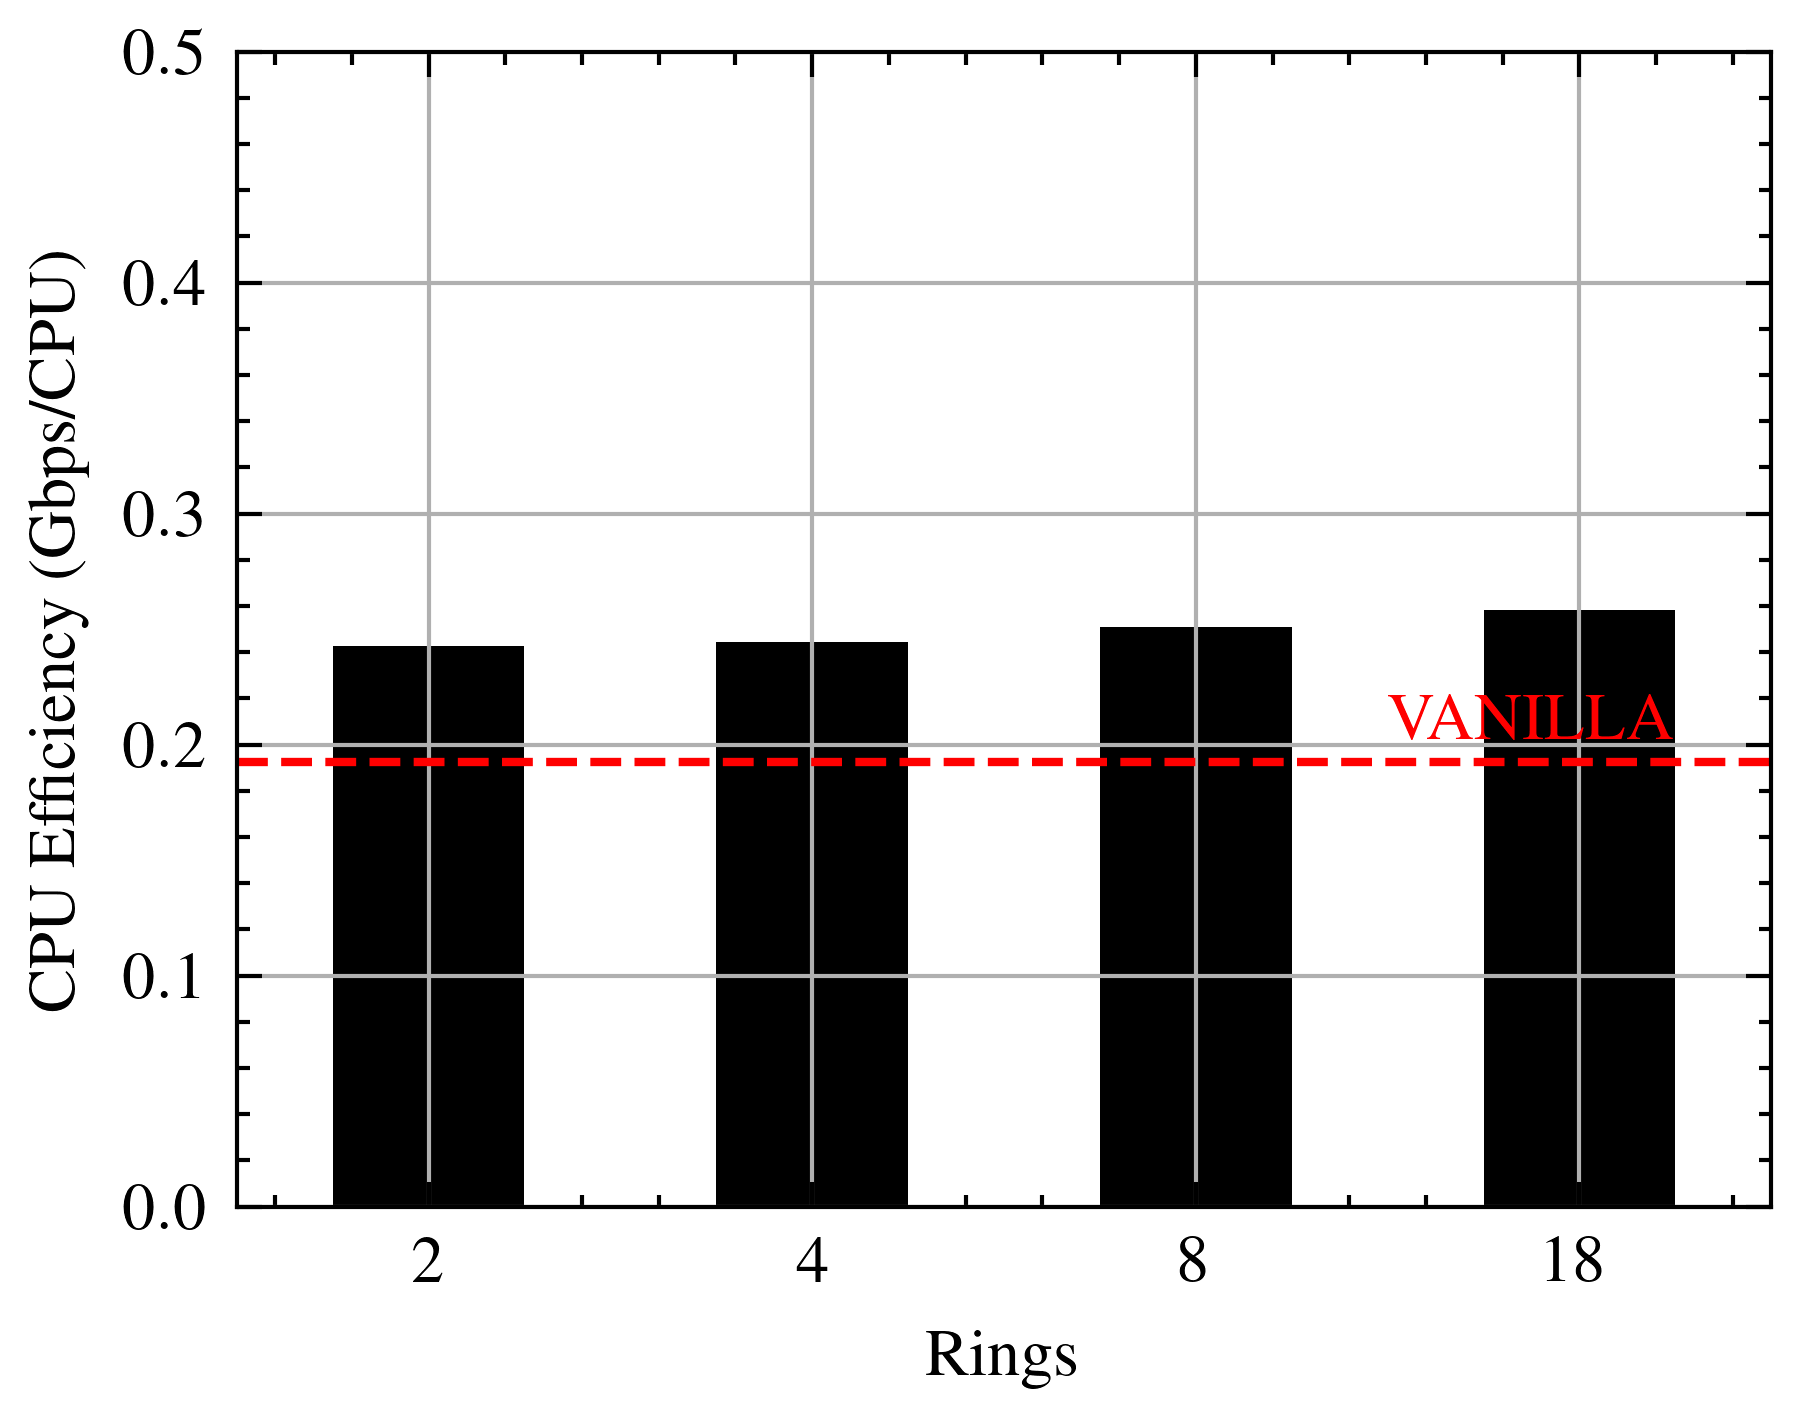

In [160]:
df = mq_steering
x = 'rings'

plot_(
    df, x=x, y='throughput', ylim=[0, 25],
    xlabel='Rings', ylabel='Throughput in Gbps',
    normal_value=vanilla['throughput'].iloc[0],
    text_spacing=.2, text_offset=-0.3
)

plot_(
    df, x=x, y='latency', ylim=[0, 150],
    xlabel='Rings', ylabel='p99 Latency in ms',
    normal_value=vanilla['latency'].iloc[0],
    text_spacing=3, text_offset=-0.3
)

metric = 'cpu_efficiency'
plot_(
    df, x=x, y=metric, ylim=[0, .5],
    xlabel='Rings', ylabel='CPU Efficiency (Gbps/CPU)',
    normal_value=vanilla[metric].iloc[0],
    text_spacing=.01, text_offset=2.5
)

# Comparison of bests

In [177]:
mq_best = mq_steering[mq_steering.rings == 4]
batched_best = batched[batched.batch == 4]

In [178]:
mq_best

,rings,throughput,latency,cpu,cpu_efficiency,variant
4,4,19.719093,20.8656,80.701389,0.244346,MULTI_QUEUE


In [179]:
df = pd.concat(
    [vanilla, no_queue, batched_best, mq_best],
    axis=0
).reset_index()

In [180]:
df

,index,throughput,latency,cpu,cpu_efficiency,variant,batch,rings
0,0,19.237766,124.675000,100.000000,0.192378,VANILLA,NaN,NaN
1,0,20.854481,88.661387,31.909444,0.653552,NO_QUEUE,NaN,NaN
2,1,20.688951,52.027700,81.927917,0.252526,BATCHED,4.0,NaN
3,4,19.719093,20.865600,80.701389,0.244346,MULTI_QUEUE,NaN,4.0


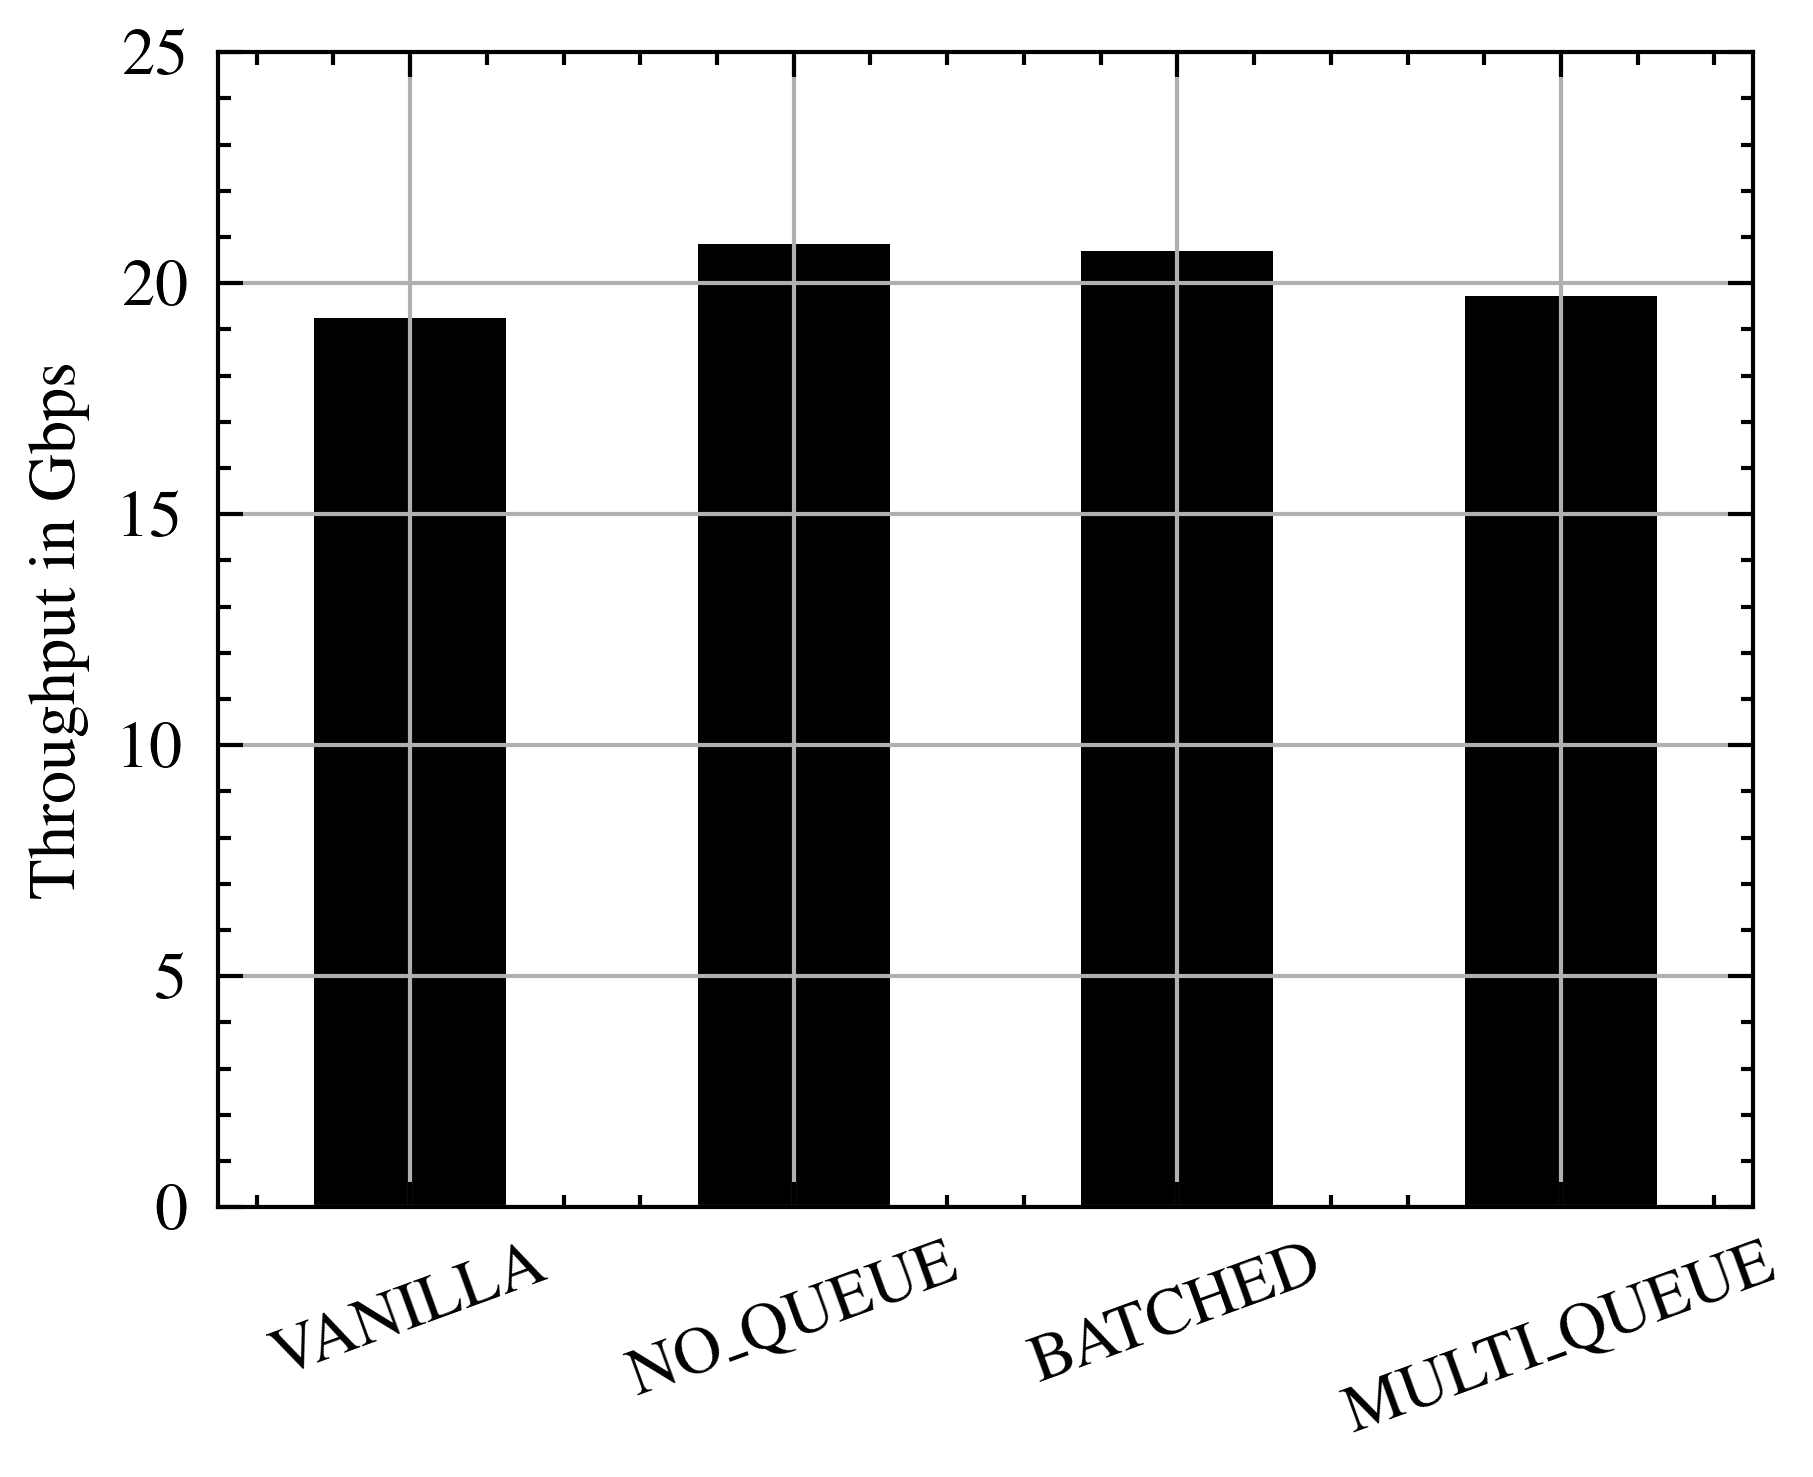

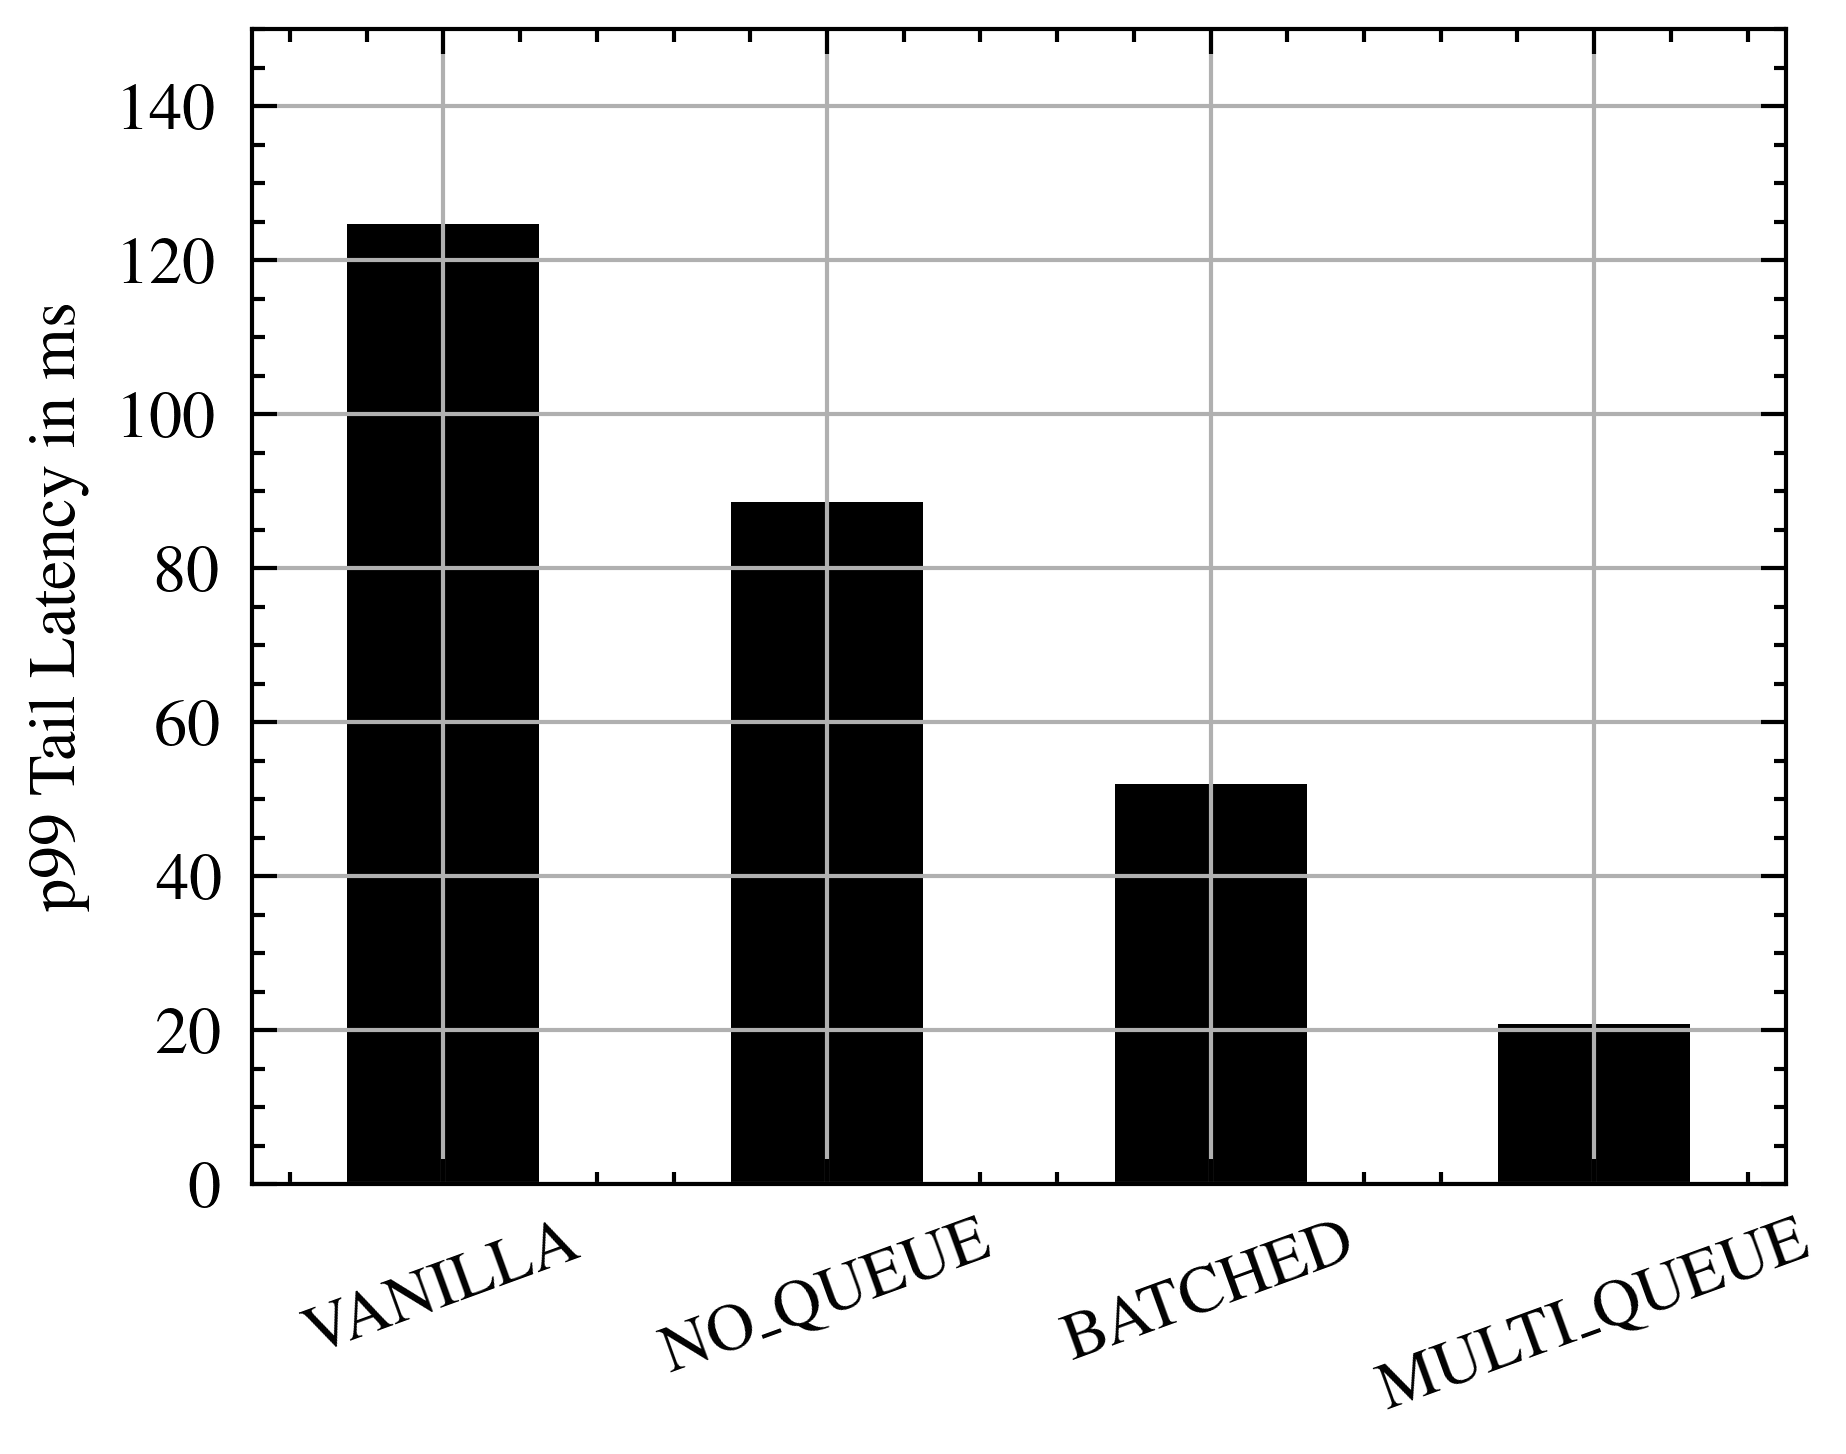

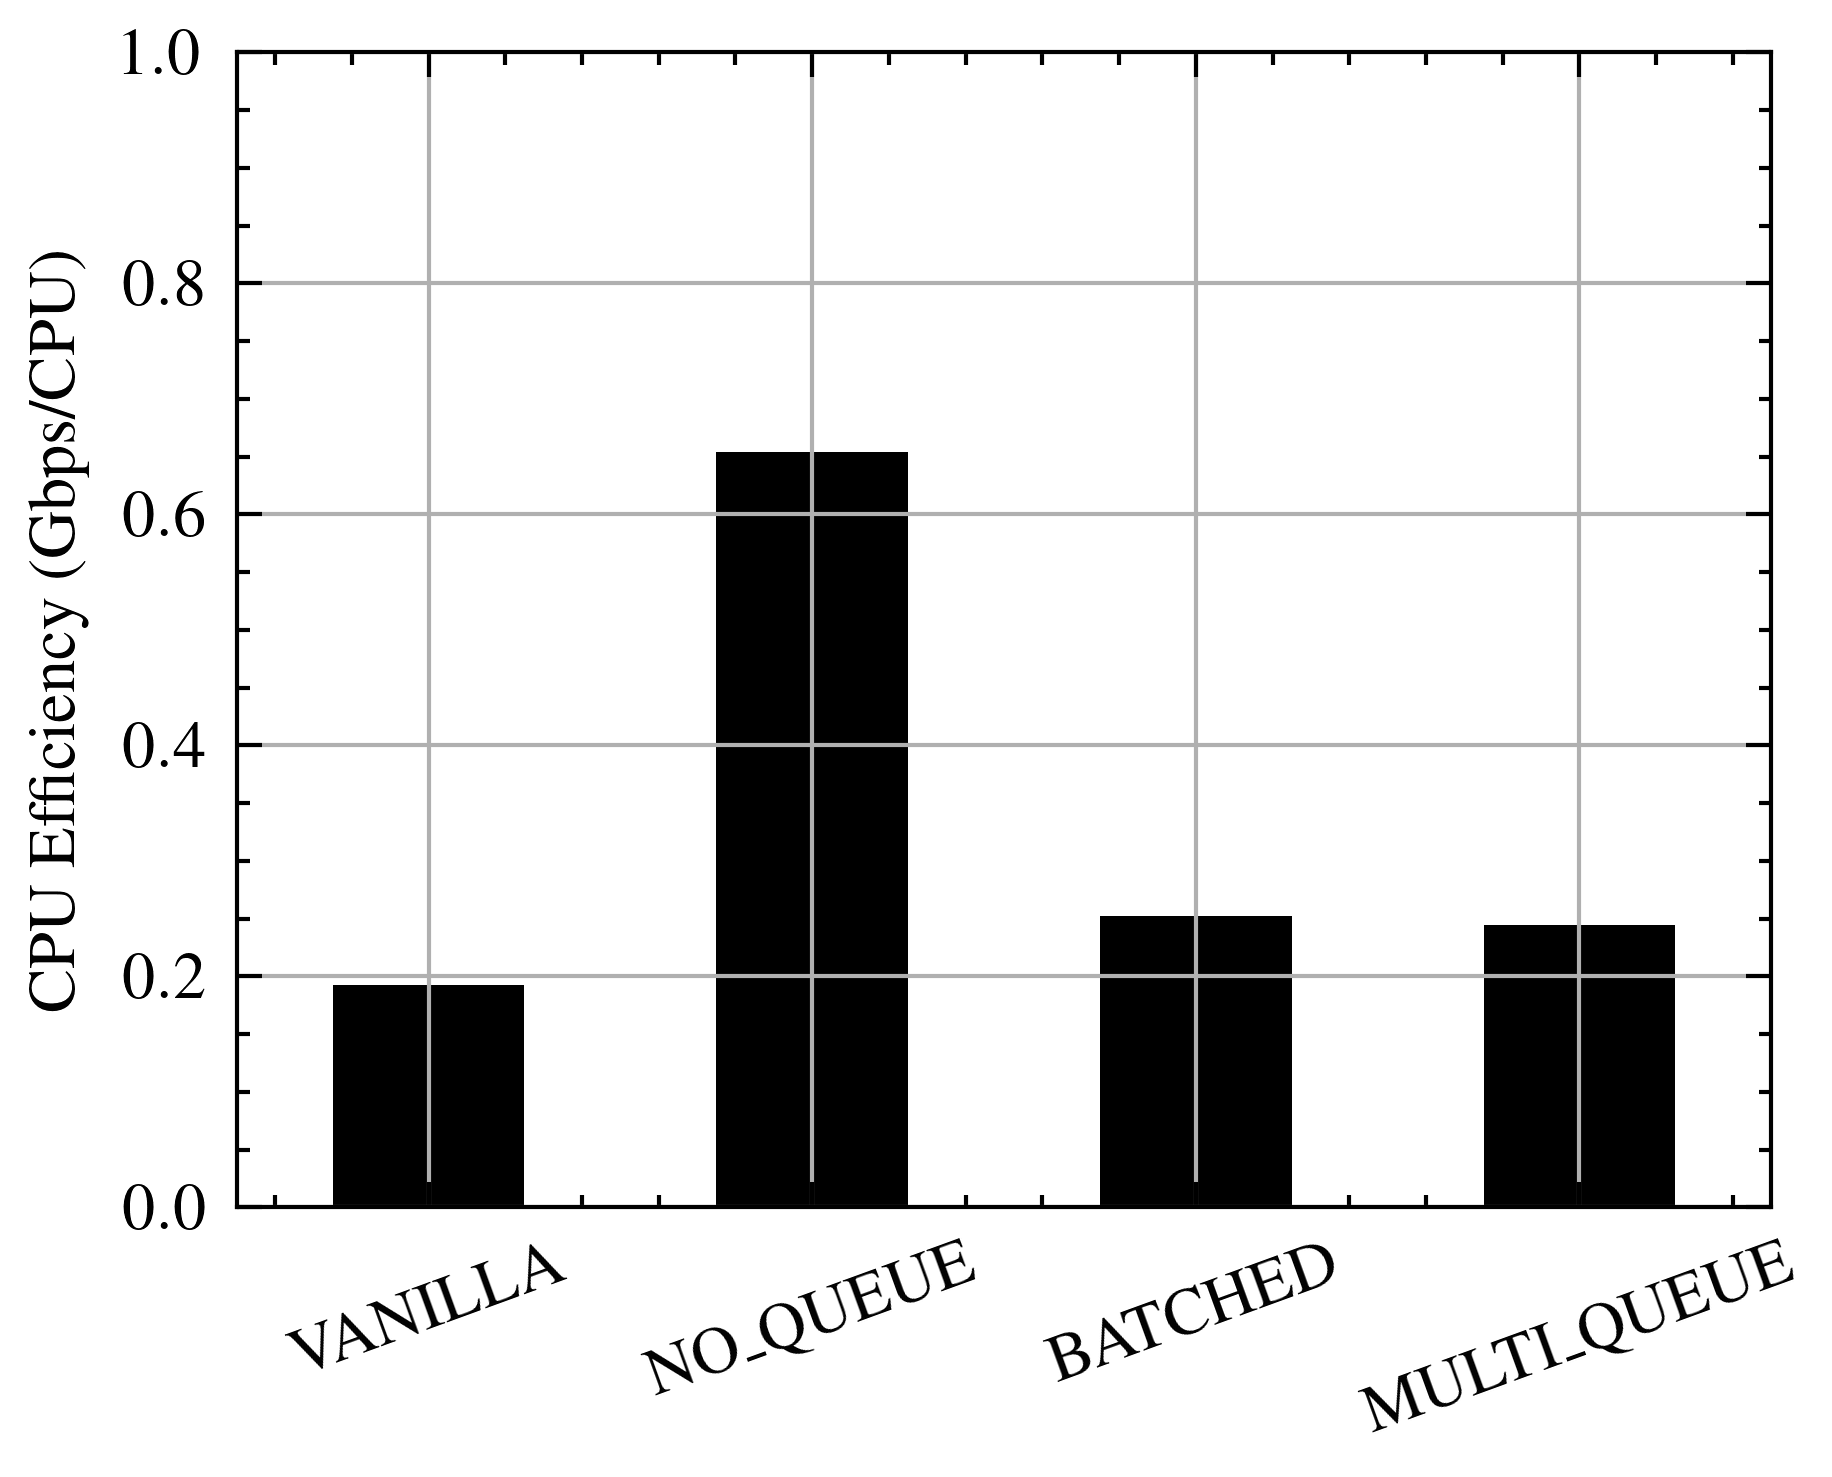

In [189]:
with plt.style.context(['science', 'ieee']):
    df.plot.bar(
        x='variant', y='throughput', legend=None, grid=True,
        ylabel="Throughput in Gbps", ylim=[0, 25], xlabel="",
    )
    plt.xticks(rotation=20)
    plt.show()

    df.plot.bar(
        x='variant', y='latency', legend=None, grid=True,
        ylabel="p99 Tail Latency in ms", ylim=[0, 150], xlabel="",
    )
    plt.xticks(rotation=20)
    plt.show()

    df.plot.bar(
        x='variant', y='cpu_efficiency', legend=None, grid=True,
        ylabel="CPU Efficiency (Gbps/CPU)", ylim=[0, 1], xlabel="",
    )
    plt.xticks(rotation=20)
    plt.show()